In [2]:
!pip install deep_tabular_augmentation

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for deep-tabular-augmentation: filename=deep_tabular_augmentation-0.5.3-py3-none-any.whl size=7933 sha256=480cd2baf1a4b1240ea4eb2387e9b72e8aff1f092293795b3800ac09e05fe60d
  Stored in directory: /home/user/.cache/pip/wheels/08/12/11/9565e20b3fe6fd8c76ad6fd5ddc3e044476709408066fec146
Successfully built deep-tabular-augmentation


In [3]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import deep_tabular_augmentation as dta
from vpower.src.utils.auxiliary_functions import *
import matplotlib.pyplot as plt

In [6]:
data_dir_s =  "../../../data/synthetic_data"
data_dir_r =  "../../../data/real_data"
data_tag="RD"

In [7]:
# Load data partitions and assign them to dictionary data_all
data_all = {}
for partition in ["train", "dev_in", "dev_out"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_s, f"{partition}.csv"), index_column_name="time_id")
    data_all[partition+"_s"] = df
for partition in ["train", "dev_in", "dev_out"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="time_id")
    data_all[partition+"_r"] = df

if data_tag=="RD":
    data_all["train"]=data_all["train_r"]
    data_all["dev_in"]=data_all["dev_in_r"]
else:
    data_all["train"]=   pd.concat([data_all["train_r"], data_all["train_s"]])
    data_all["dev_in"] = pd.concat([data_all["dev_in_r"], data_all["dev_in_s"]])
    
    

In [8]:
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(data_all["train"])
X_test_scaled = x_scaler.fit_transform(data_all["dev_in"])
datasets = dta.create_datasets_no_target_var(X_train_scaled, X_test_scaled)
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

In [18]:
datasets = dta.create_datasets_no_target_var(data_all["train"], data_all["dev_in"])
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

ValueError: could not determine the shape of object type 'DataFrame'

In [23]:
D_in = X_train_scaled.shape[1]
#VAE_arch = [50, 12, 12]
VAE_arch = [25,5,5]
df_cols = list(df.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=3).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [25]:
D_in

11

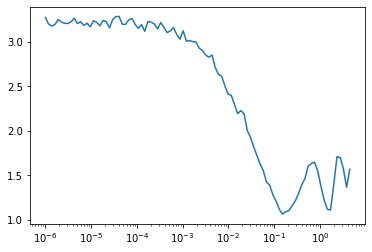

In [24]:
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)
run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])
run.fit(10000, learn)
run.recorder.plot(skip_last=5)

In [11]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

In [13]:
cbfs = [partial(dta.LossTracker, show_every=25), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=3).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(100, learn)

epoch: 25
train loss is: 1.0705175399780273
validation loss is: 1.0004318952560425
epoch: 50
train loss is: 1.0030810832977295
validation loss is: 1.0005511045455933
epoch: 75
train loss is: 1.0019985437393188
validation loss is: 1.0007177591323853
epoch: 100
train loss is: 1.001833438873291
validation loss is: 1.000890851020813
epoch: 125
train loss is: 1.001887321472168
validation loss is: 1.001085638999939
epoch: 150
train loss is: 1.001964807510376
validation loss is: 1.0012587308883667
epoch: 175
train loss is: 1.0020256042480469
validation loss is: 1.0013304948806763
epoch: 200
train loss is: 1.002057433128357
validation loss is: 1.0013848543167114
epoch: 225
train loss is: 1.0020489692687988
validation loss is: 1.0014734268188477
epoch: 250
train loss is: 1.0020256042480469
validation loss is: 1.0015392303466797
epoch: 275
train loss is: 1.0019810199737549
validation loss is: 1.0015572309494019
epoch: 300
train loss is: 1.001928687095642
validation loss is: 1.0015314817428589
ep

In [14]:
store_path = "models/DA"
torch.save(model.state_dict(), os.path.join(store_path, "da_best_mix_model_v3.pth"))

In [15]:
new_data_points = 1000
df_fake = run.predict_df(learn, no_samples=new_data_points, scaler=x_scaler)
std_list = list(df[df_cols].std()/10)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=new_data_points, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

,draft_aft_telegram,draft_fore_telegram,stw,diff_speed_overground,awind_vcomp_provider,awind_ucomp_provider,rcurrent_vcomp,rcurrent_ucomp,comb_wind_swell_wave_height,timeSinceDryDock,power
0,12.050596,11.984622,17.188829,-0.014236,17.061135,5.749947,-0.012851,-0.065715,1.450543,982667.084422,20118.157280
1,12.371558,11.964206,17.342361,0.011801,15.460913,6.395746,0.010635,-0.010541,1.445585,970179.246533,21527.318522
2,12.383807,12.124013,17.389922,-0.006766,16.738109,4.472031,-0.037734,0.008862,1.587573,970284.479912,19278.746523
3,12.398338,11.871444,17.212068,0.021367,15.306503,6.132759,0.085186,0.029446,1.664444,991951.816414,20172.317047
4,12.284426,12.048358,17.708708,0.008363,19.080306,6.548166,0.003903,-0.009227,1.478822,983192.380665,20642.877854


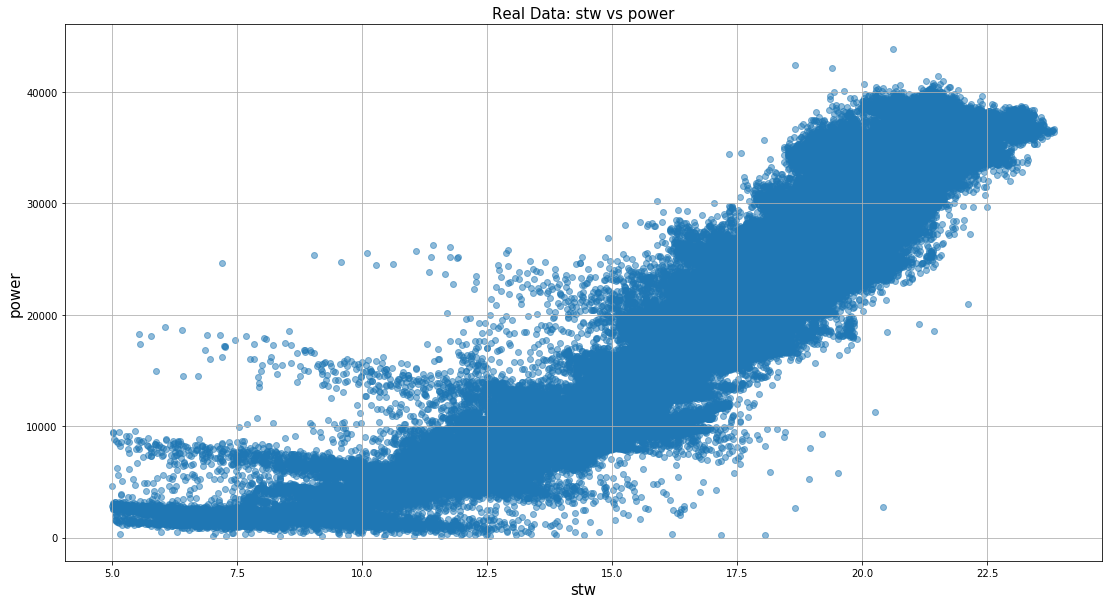

In [16]:
df1=data_all["train"]

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(df1['stw'], df1['power'], alpha=0.5)

ax.set_xlabel('stw', fontsize=15)
ax.set_ylabel('power', fontsize=15)
ax.set_title('Real Data: stw vs power', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()

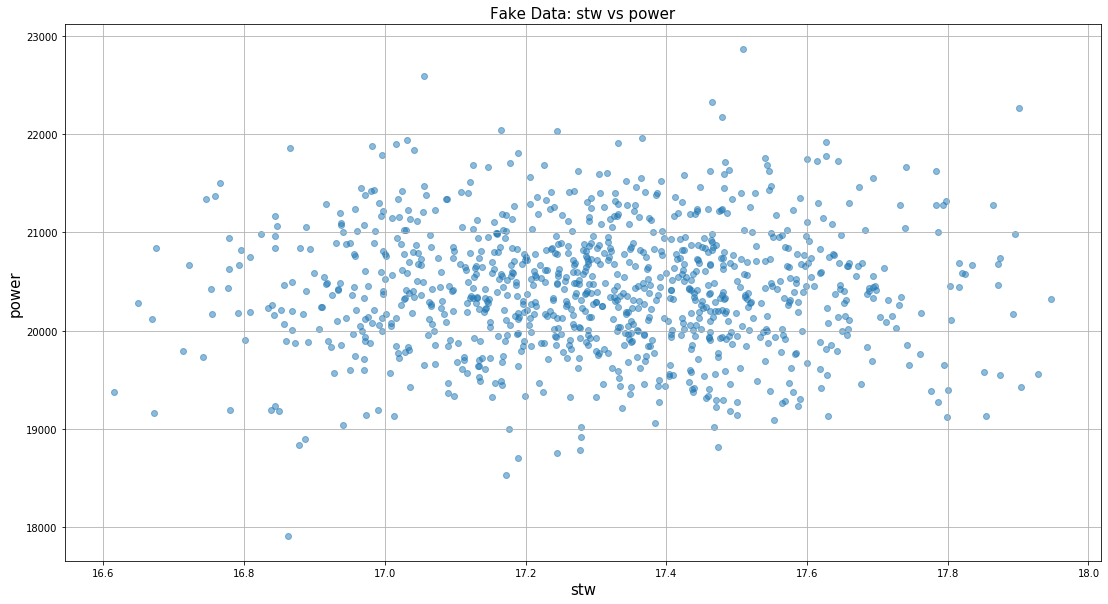

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(df_fake_with_noise['stw'], df_fake_with_noise['power'], alpha=0.5)

ax.set_xlabel('stw', fontsize=15)
ax.set_ylabel('power', fontsize=15)
ax.set_title('Fake Data: stw vs power', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()

In [ ]:
feature_under_study = "awind_vcomp_provider"

plt.figure(figsize=(6, 6))
plt.scatter(df_fake_with_noise["stw"], df_fake_with_noise["power"] / 1e3,
            c=df_fake_with_noise[feature_under_study],
            s=4, label="TRAIN")
plt.legend(loc="upper left")
plt.xlabel("Speed (knots)")
plt.ylabel("Power (MW)")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()